# Analyza liekov podla skupiny ATC1 
## Otazky:
* Ktore skupiny liekov sa najviac spotrebuvaju ?
* Ako sa meni spotreba podla jednotlivych kategorii ?
* Ako to suvisi s pandemiou ?

In [62]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%run tables.py

In [64]:
# Creating: detailed_table[year] 

detailed_tables = {}
for year in range(2015,2020):
    detailed_tables[year] = import_table('detailed',year).groupby('ATC1_popis').sum().sort_values(by='Počet balení',ascending=False)
    del detailed_tables[year]['ROK SPRAC']
    detailed_tables[year]['CENA'] =  detailed_tables[year]['Úhrada_SPOLU'] / detailed_tables[year]['Počet balení']
display(2019)
display(detailed_tables[2019].head())

2019

,Počet balení,Úhrada_ZP,Úhrada_PAC,Úhrada_SPOLU,CENA
ATC1_popis,,,,,
Kardiovaskulárny systém,3.009478e+07,1.366732e+08,73614509.50,2.102878e+08,6.987516
Nervový systém,2.528963e+07,1.029034e+08,58926530.22,1.618300e+08,6.399066
Tráviaci trakt a metabolizmus,2.003817e+07,1.562717e+08,76696058.77,2.329677e+08,11.626196
Respiračný systém,1.780014e+07,5.968704e+07,73856187.61,1.335432e+08,7.502369
Krv a krvotvorné orgány,1.367591e+07,2.253825e+08,13245441.18,2.386280e+08,17.448775


In [ ]:
# Creating: detailed_table[2020] 

temp = import_table('detailed',2020) 
detailed_tables[2020] = temp['Q1'].groupby('ATC1_popis').sum().sort_index()
#display(temp['Q1'].groupby('ATC1_popis').sum().sort_index().shape)
for i in range(2,4):
    #display(temp[f'Q{i}'].groupby('ATC1_popis').sum().sort_index().shape)
    detailed_tables[2020] =  detailed_tables[2020] + temp[f'Q{i}'].groupby('ATC1_popis').sum().sort_index()
del detailed_tables[2020]['ROK SPRAC']
detailed_tables[2020] = detailed_tables[2020].sort_values(by='Počet balení',ascending=False)
detailed_tables[2020]['Počet balení_estimated'] = detailed_tables[2020]['Počet balení']/75 * 100
display(detailed_tables[2020].head())

In [65]:
temp = {}
temp['ATC1_popis'] = []
for i in detailed_tables[2020].index:
    temp['ATC1_popis'] += [i]
    for j in range(2015,2021):
        if j not in temp:
            temp[j] = []
        if j ==2019 and i == '(prázdne)':
            temp[j] += [detailed_tables[j].loc['(prazdne)','Počet balení']]
        elif j == 2020:
            temp[j] += [detailed_tables[j].loc[i,'Počet balení_estimated']]
        else:
            temp[j] += [detailed_tables[j].loc[i,'Počet balení']]
detailed_tables['all'] =  pd.DataFrame(temp).set_index('ATC1_popis')
detailed_tables['all'] = detailed_tables['all'].rename(index={'Systémové hormonálne prípravky okrem pohlavných hormónov':'Hormonálne prípravky okrem pohlavných'})
display(detailed_tables['all'].head())

KeyError: 2020

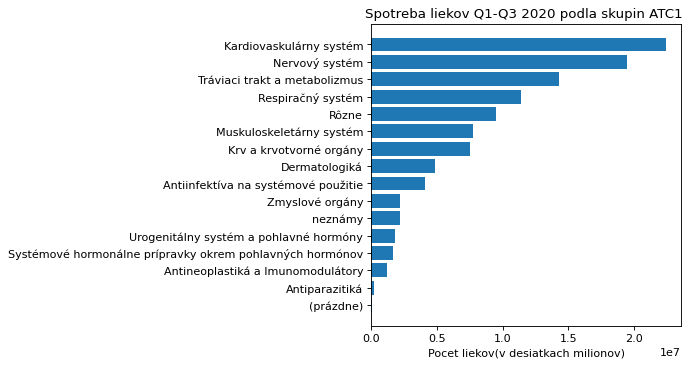

In [67]:
plt.figure(figsize=(5, 5), dpi=80)
plt.barh(y=detailed_tables[2020].sort_values(by='Počet balení',ascending=True).index,
width=detailed_tables[2020].sort_values(by='Počet balení',ascending=True)['Počet balení'])
plt.xlabel('Pocet liekov(v desiatkach milionov)')
plt.title('Spotreba liekov Q1-Q3 2020 podla skupin ATC1 ')
plt.show()

## Pozorovanie
Na grafe je vidiet ze v roku 2020 bolo najviac spotrebovanych liekov v oblastiach:
* Kardiovaskulárny systém
* Nervový systém
* Tráviaci trakt a metabolizmus
* Respiračný systém
* Rôzne
* Muskuloskeletárny systém

Dalej chceme zistit ci rastie alebo klesa spotreba liekov v tych oblastiach

In [68]:
temp = import_table('all',2019)
tab2019_Q13 = temp['Q1'].loc[:,['LIEK_popis','Počet balení_Q1']].rename(columns={'Počet balení_Q1':'Počet balení_Q1-Q3'})
for index in 'Q2','Q3':
    tab2019_Q13['Počet balení_Q1-Q3'] += temp[index][f'Počet balení_{index}']

temp = import_table('detailed',2019)
temp.drop_duplicates(subset='LIEK_popis',inplace=True)
temp = temp[['LIEK_popis','ATC1_popis']]

tab2019_Q13 = tab2019_Q13.merge(temp,on='LIEK_popis').groupby('ATC1_popis').sum().sort_values(by='Počet balení_Q1-Q3',ascending=False)
tab2019_Q13 = tab2019_Q13.rename(index={'(prazdne)':'(prázdne)'})
display(tab2019_Q13.head())

,Počet balení_Q1-Q3
ATC1_popis,
Kardiovaskulárny systém,2.232247e+07
Nervový systém,1.840355e+07
Tráviaci trakt a metabolizmus,1.452565e+07
Respiračný systém,1.256299e+07
Krv a krvotvorné orgány,1.071284e+07


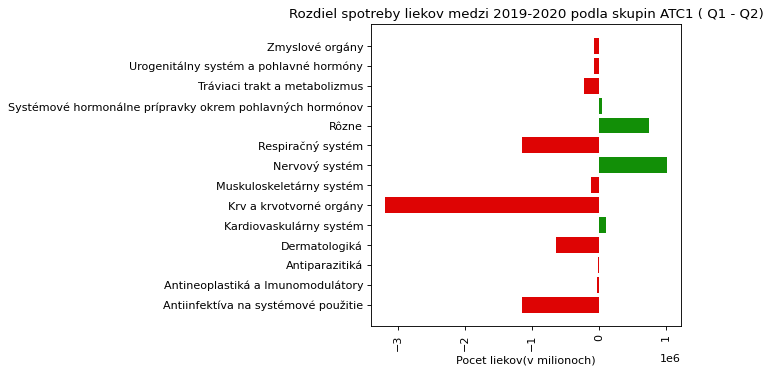

In [69]:
temp2020 = detailed_tables[2020].sort_index()
temp2019 = tab2019_Q13.sort_index()

temp2019 =  temp2019.drop(index=['neznámy',"(prázdne)"])
temp2020 =  temp2020.drop(index=['neznámy',"(prázdne)"])

color = ['#de0404' if diff < 0 else '#128f07' for diff in temp2020['Počet balení'] - temp2019['Počet balení_Q1-Q3']]

plt.figure(figsize=(5, 5), dpi=80)
plt.barh(width= temp2020['Počet balení'] - temp2019['Počet balení_Q1-Q3'] , y=temp2020.sort_index().index,color=color)
plt.xticks(rotation=90)
plt.xlabel('Pocet liekov(v milionoch)')
plt.title('Rozdiel spotreby liekov medzi 2019-2020 podla skupin ATC1 ( Q1 - Q2)')
plt.show()

## Pozorovanie
Z kategorii z ktorych najviac liekov se spotrebovali za rok 2020 zazili narast:
* Nervovy system
* Rozne

Ostatne kategorie bud stagnju alebo zazivaju znacny pokles, co je pozitivna sprava. To moze byt zapricinene zlepsujucim zivotnym standartom.

Poznamky:
* Preco ludia viac uzivaju lieky na nervovy system  ? 
* Zvysila sa spotreba vaznejsich liekov alebo menej vaznych ?
* Expandovala definicia pre kategoriu rozne ?


In [70]:
temp = import_table('detailed',2020)
neural_drugs = temp['Q1'].query('ATC1_popis == "Nervový systém"').groupby('ATC7_popis').sum()
del neural_drugs['ROK SPRAC']
temp['Q2'] =  temp['Q2'].query('ATC1_popis == "Nervový systém"').groupby('ATC7_popis').sum()
temp['Q3'] =  temp['Q3'].query('ATC1_popis == "Nervový systém"').groupby('ATC7_popis').sum()
for i in ('Q2','Q3'):
    for index in temp[i].index:
        if index in neural_drugs.index:
            neural_drugs.loc[index,'Počet balení'] += temp[i].loc[index,'Počet balení']
        else:
            neural_drugs = neural_drugs.append(pd.Series(data={'Počet balení':temp[i].loc[index,'Počet balení']},name=index),ignore_index=False)
neural_drugs =  neural_drugs.sort_values(by='Počet balení',ascending=False)
display(neural_drugs.sort_values(by='Počet balení',ascending=False).shape)
display(neural_drugs.head(10))


(183, 1)

,Počet balení
ATC7_popis,
Paracetamol,2955023.496
Alprazolam,1570134.300
"Metamizol, sodná soľ",1486818.990
Zolpidém,1187346.009
"Paracetamol, kombinácie okrem psycholeptík",884636.374
Kyselina acetylsalicylová,698367.580
Tramadol a paracetamol,489497.434
Mefenoxalón,455632.870
"Paracetamol, kombinácie s psycholeptikami",437223.369


### poznamka:
* zistit ktore latky by sa dali nazvat relaxantami alebo antidepresivami
* vytvorit graf ktory znazornuje priebeh pouivania tychto latok od roku 2015 po dnes
* pozriet ci sa nezvysila spotreba liekov s antidepresivnymi latkami po zacati pandemie